In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import data
df = pd.read_csv('weather_data.csv')
df.head()

,Date Time,T (degC),p (mbar)
0,01.01.2009 00:10:00,-8.02,996.52
1,01.01.2009 00:20:00,-8.41,996.57
2,01.01.2009 00:30:00,-8.51,996.53
3,01.01.2009 00:40:00,-8.31,996.51
4,01.01.2009 00:50:00,-8.27,996.51


#### Starting from 5, take every 6th, that is ever hour , original df has 10 mins interval

In [3]:
df = df[5::6]
df

,Date Time,T (degC),p (mbar)
5,01.01.2009 01:00:00,-8.05,996.50
11,01.01.2009 02:00:00,-8.88,996.62
17,01.01.2009 03:00:00,-8.81,996.84
23,01.01.2009 04:00:00,-9.05,996.99
29,01.01.2009 05:00:00,-9.63,997.46
...,...,...,...
420521,31.12.2016 19:10:00,-0.98,1002.18
420527,31.12.2016 20:10:00,-1.40,1001.40
420533,31.12.2016 21:10:00,-2.75,1001.19
420539,31.12.2016 22:10:00,-2.89,1000.65


The resulting dataframe, df, now consists of rows that represent data at one-hour intervals from the original dataframe, which had a 10-minute interval. The displayed output shows the "Date Time," "T (degC)" (temperature), and "p (mbar)" (pressure) columns for each selected hour. The dataframe has a total of 70091 rows and 3 columns.

#### Convert to pandas datetime

In [4]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df.head()


,Date Time,T (degC),p (mbar)
Date Time,,,
2009-01-01 01:00:00,01.01.2009 01:00:00,-8.05,996.50
2009-01-01 02:00:00,01.01.2009 02:00:00,-8.88,996.62
2009-01-01 03:00:00,01.01.2009 03:00:00,-8.81,996.84
2009-01-01 04:00:00,01.01.2009 04:00:00,-9.05,996.99
2009-01-01 05:00:00,01.01.2009 05:00:00,-9.63,997.46


### Focusing on T(degC) column (Univariate)

#### Ploting the time series

<Axes: xlabel='Date Time'>

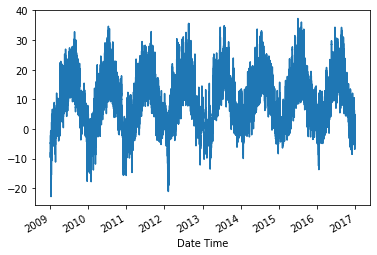

In [5]:
# Plot temperature data
temp = df['T (degC)']
temp.plot()

#### Making each row a matrix input


This function creates input matrices (X) and output vectors (y) for a time series prediction task. Each row of the input matrix represents a window of window_size consecutive rows from the original DataFrame. The corresponding output is the value in the next time step after the window. The function returns the input matrix (X) and output vector (y).

In [6]:
# [[[1], [2], [3], [4], [5]]] [6], take last five to predict the 6th,,,, 1-5 is appended to X, 6 to y
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [7]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((70086, 5, 1), (70086,))

Explanation:

WINDOW_SIZE Definition:

WINDOW_SIZE = 5: The code sets a window size of 5 for creating input matrices and output vectors.
Function Call:

X1, y1 = df_to_X_y(temp, WINDOW_SIZE): Calls the df_to_X_y function with the temperature data (temp) and the specified window size (WINDOW_SIZE).
Generated Matrices and Vectors:

X1.shape, y1.shape: Prints the shapes of the generated input matrices (X1) and output vectors (y1).
Result of Focal Cell:

((70086, 5, 1), (70086,)): The resulting shapes indicate that X1 is a 3D array with dimensions (70086, 5, 1), and `

#### Splitting the model

In [8]:
# Split the data into Training, testinga and validation sets

# Training set
X_train1, y_train1 = X1[:60000], y1[:60000]
# Validation set
X_val1, y_val1 = X1[60000:65000], y1[60000:65000]
# Testing set
X_test1, y_test1 = X1[65000:], y1[65000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((60000, 5, 1), (60000,), (5000, 5, 1), (5000,), (5086, 5, 1), (5086,))

Explanation:

X_train1, y_train1 = X1[:60000], y1[:60000]: Splits the input matrix X1 and output vector y1 into training data with the first 60,000 samples.

X_val1, y_val1 = X1[60000:65000], y1[60000:65000]: Creates a validation set with samples from 60,000 to 64,999 from the input matrix X1 and output vector y1.

X_test1, y_test1 = X1[65000:], y1[65000:]: Forms a test set using samples from 65,000 onwards in the input matrix X1 and output vector y1.

X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape: Prints the shapes of the resulting training, validation, and testing sets.

In [9]:
# Import necessary libraries 
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam



In [10]:
# Create a Sequential model
model1 = Sequential()

# Add an input layer with shape (5, 1)
model1.add(InputLayer((5, 1)))

# Add an LSTM layer with 64 units
model1.add(LSTM(64))

# Add a Dense layer with 8 units and 'relu' activation function
model1.add(Dense(8, activation='relu'))

# Add a Dense layer with 1 unit and 'linear' activation function
model1.add(Dense(1, activation='linear'))

# Print a summary of the model's architecture
model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Explanation:

model1 = Sequential(): Initializes a sequential model, allowing the addition of layers in a linear stack.

model1.add(InputLayer((5, 1))): Adds an input layer with a shape of (5, 1), indicating the input data has 5 time steps and 1 feature.

model1.add(LSTM(64)): Adds an LSTM layer with 64 units.

model1.add(Dense(8, activation='relu')): Adds a Dense layer with 8 units and a Rectified Linear Unit (ReLU) activation function.

model1.add(Dense(1, activation='linear')): Adds another Dense layer with 1 unit and a linear activation function.

model1.summary(): Prints a summary of the model architecture, including information about the layers, output shapes, and parameters.

The summary indicates that the model has a total of 17,425 parameters, all of which are trainable. The model uses an LSTM layer followed by Dense layers for processing and prediction.

#### To specify our model copacks

In [11]:
# To specify our model checkpoints
cp1 = ModelCheckpoint('model1/', save_best_only=True)

# Compile the model with Mean Squared Error as the loss function, Adam optimizer with a learning rate of 0.0001,
# and Root Mean Squared Error as the evaluation metric
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

cp1 = ModelCheckpoint('model1/', save_best_only=True): Creates a ModelCheckpoint object named cp1 to save the best model during training. It will save the model in the 'model1/' directory and only overwrite the file if the new model is better than the previous best.

model1.compile(...): Configures the training process for the model. It sets the loss function to Mean Squared Error, the optimizer to Adam with a learning rate of 0.0001, and includes Root Mean Squared Error as a metric for evaluation during training.

This code prepares the model for training and ensures that the best version of the model is saved using checkpoints during the training process.

#### Fit the model

In [12]:
# Fit the model using training data (X_train1, y_train1) and validate on validation data (X_val1, y_val1) for 10 epochs
# Callbacks include ModelCheckpoint (cp1) to save the best model during training
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])

Epoch 1/10

1870/1875 [============================>.] - ETA: 0s - loss: 49.5947 - root_mean_squared_error: 7.0424INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 15s 7ms/step - loss: 49.4767 - root_mean_squared_error: 7.0340 - val_loss: 1.6221 - val_root_mean_squared_error: 1.2736
Epoch 2/10
1869/1875 [============================>.] - ETA: 0s - loss: 2.8673 - root_mean_squared_error: 1.6933INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 11s 6ms/step - loss: 2.8609 - root_mean_squared_error: 1.6914 - val_loss: 0.6485 - val_root_mean_squared_error: 0.8053
Epoch 3/10
1859/1875 [============================>.] - ETA: 0s - loss: 1.0182 - root_mean_squared_error: 1.0091INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 12s 6ms/step - loss: 1.0171 - root_mean_squared_error: 1.0085 - val_loss: 0.5360 - val_root_mean_squared_error: 0.7321
Epoch 4/10
1872/1875 [============================>.] - ETA: 0s - loss: 0.7512 - root_mean_squared_error: 0.8667INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 12s 7ms/step - loss: 0.7514 - root_mean_squared_error: 0.8668 - val_loss: 0.5299 - val_root_mean_squared_error: 0.7280
Epoch 5/10
1872/1875 [============================>.] - ETA: 0s - loss: 0.6906 - root_mean_squared_error: 0.8310INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 14s 8ms/step - loss: 0.6905 - root_mean_squared_error: 0.8310 - val_loss: 0.4987 - val_root_mean_squared_error: 0.7062
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.6690 - root_mean_squared_error: 0.8179 - val_loss: 0.5249 - val_root_mean_squared_error: 0.7245
Epoch 7/10
1873/1875 [============================>.] - ETA: 0s - loss: 0.6591 - root_mean_squared_error: 0.8119INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 12s 7ms/step - loss: 0.6592 - root_mean_squared_error: 0.8119 - val_loss: 0.4922 - val_root_mean_squared_error: 0.7016
Epoch 8/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.6534 - root_mean_squared_error: 0.8083 - val_loss: 0.5103 - val_root_mean_squared_error: 0.7143
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6496 - root_mean_squared_error: 0.8060 - val_loss: 0.5215 - val_root_mean_squared_error: 0.7221
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6470 - root_mean_squared_error: 0.8044 - val_loss: 0.4990 - val_root_mean_squared_error: 0.7064


Loss, RMSE and validation loss(which is the most important)all decreased, and the model was saved at 0.4990 which was the lowest

In [13]:
# Load the model with the lowest validation loss to memory
from tensorflow.keras.models import load_model

# Load the best model saved during training from the 'model1/' directory
model1 = load_model('model1/')

#### Predictions

On the training data

In [14]:
# Predictions on the training data using the trained model (model1)

# The following line generates predictions using the trained model on the training data
train_predictions = model1.predict(X_train1).flatten()

# Creating a DataFrame to display the predicted values alongside the actual values
train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals': y_train1})

# Display the DataFrame with the predicted and actual values
train_results

1875/1875 [==============================] - 6s 3ms/step


,Train Predictions,Actuals
0,-9.819400,-9.67
1,-9.665568,-9.17
2,-8.814911,-8.10
3,-7.368946,-7.66
4,-7.267952,-7.04
...,...,...
59995,6.118703,6.07
59996,7.174312,9.88
59997,12.004978,13.53
59998,15.653346,15.43


#### Plotting

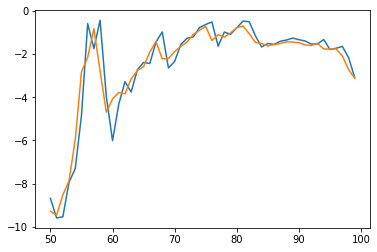

In [15]:
# Plotting
plt.plot(train_results['Train Predictions'][50:100])  # Plot predictions on training data from index 50 to 100
plt.plot(train_results['Actuals'][50:100])           # Plot actual values on training data from index 50 to 100

#### Lets see how it did on the validation data

In [16]:
# Predictions on the validation data using the trained model (model1)

# The following line generates predictions using the trained model on the validation data
val_predictions = model1.predict(X_val1).flatten()

# Creating a DataFrame to display the predicted values alongside the actual values for the validation data
val_results = pd.DataFrame(data={'Val Predictions': val_predictions, 'Actuals': y_val1})

# Display the DataFrame with the predicted and actual values for the validation data
val_results

157/157 [==============================] - 1s 3ms/step


,Val Predictions,Actuals
0,15.381510,14.02
1,13.130645,13.67
2,13.087084,12.27
3,11.567726,11.19
4,10.449093,10.85
...,...,...
4995,17.466074,18.27
4996,17.531942,17.85
4997,17.283659,16.65
4998,15.958948,15.85


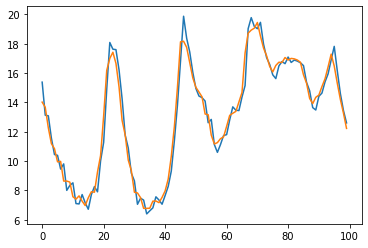

In [17]:
# Plotting
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

#### and on the test dataset

In [18]:
# Predictions on the test dataset using the trained model (model1)

# The following line generates predictions using the trained model on the test data
test_predictions = model1.predict(X_test1).flatten()

# Creating a DataFrame to display the predicted values alongside the actual values for the test data
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Actuals': y_test1})

# Display the DataFrame with the predicted and actual values for the test data
test_results

159/159 [==============================] - 0s 3ms/step


,Test Predictions,Actuals
0,14.489413,13.99
1,13.339381,13.46
2,12.941147,12.93
3,12.525792,12.43
4,12.071763,12.17
...,...,...
5081,-1.171498,-0.98
5082,-1.500765,-1.40
5083,-1.675806,-2.75
5084,-3.374628,-2.89


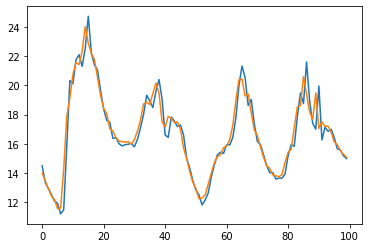

In [19]:
# Plotting
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

#### Plotting actual and predictions

In [20]:
# Plotting actual and predictions
from sklearn.metrics import mean_squared_error as mse

# Define a function to plot predictions and actual values
def plot_predictions1(model, X, y, start=0, end=100):
  # Generate predictions using the provided model
  predictions = model.predict(X).flatten()
  
  # Create a DataFrame with Predictions and Actuals for visualization
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals': y})
  
  # Plot the Predictions and Actuals within the specified range
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  
  # Return the DataFrame and Mean Squared Error (MSE) for further analysis
  return df, mse(y, predictions)

159/159 [==============================] - 0s 2ms/step


(      Predictions  Actuals
 0       14.489413    13.99
 1       13.339381    13.46
 2       12.941147    12.93
 3       12.525792    12.43
 4       12.071763    12.17
 ...           ...      ...
 5081    -1.171498    -0.98
 5082    -1.500765    -1.40
 5083    -1.675806    -2.75
 5084    -3.374628    -2.89
 5085    -3.235152    -3.93
 
 [5086 rows x 2 columns],
 0.618725827333579)

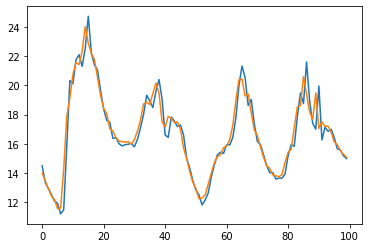

In [21]:
plot_predictions1(model1, X_test1, y_test1)

#### Adding seconds to temperature

In [22]:
# Creating a DataFrame 'temp_df' with 'Temperature' and corresponding timestamp 'Seconds'
temp_df = pd.DataFrame({'Temperature':temp})
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df

,Temperature,Seconds
Date Time,,
2009-01-01 01:00:00,-8.05,1.230772e+09
2009-01-01 02:00:00,-8.88,1.230775e+09
2009-01-01 03:00:00,-8.81,1.230779e+09
2009-01-01 04:00:00,-9.05,1.230782e+09
2009-01-01 05:00:00,-9.63,1.230786e+09
...,...,...
2016-12-31 19:10:00,-0.98,1.483211e+09
2016-12-31 20:10:00,-1.40,1.483215e+09
2016-12-31 21:10:00,-2.75,1.483219e+09


In [23]:
day = 60*60*24 # number of seconds in a day
year = 365.2425*day #Year

# Add a new df,converting period signals to sin and cos signals forday and year

temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / day))
temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Year sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / year))
temp_df['Year cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / year))
temp_df.head()

,Temperature,Seconds,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,
2009-01-01 01:00:00,-8.05,1.230772e+09,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,-8.88,1.230775e+09,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,-8.81,1.230779e+09,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,-9.05,1.230782e+09,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,-9.63,1.230786e+09,0.965926,0.258819,0.012916,0.999917


day and year are defined as the number of seconds in a day and a year, respectively.
New columns ('Day sin', 'Day cos', 'Year sin', 'Year cos') are added to temp_df.
These new columns contain sine and cosine transformations of the 'Seconds' column, representing the periodicity of the day and year.

In [24]:
# Now drop seconds since it does not loop around but is ever increasing
temp_df = temp_df.drop('Seconds', axis=1)
temp_df.head()

,Temperature,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,
2009-01-01 01:00:00,-8.05,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,-8.88,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,-8.81,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,-9.05,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,-9.63,0.965926,0.258819,0.012916,0.999917


day and year are defined as the number of seconds in a day and a year, respectively.
New columns ('Day sin', 'Day cos', 'Year sin', 'Year cos') are added to temp_df.
These new columns contain sine and cosine transformations of the 'Seconds' column, representing the periodicity of the day and year.

In [25]:
def df_to_X_y2(df, window_size=6):
  # Convert the DataFrame to a NumPy array
  df_as_np = df.to_numpy()
  X = []  # List to store input features
  y = []  # List to store labels

  # Iterate through the DataFrame array up to (len - window_size) to create input-output pairs
  for i in range(len(df_as_np)-window_size):
    # Extract a window of rows from the DataFrame as an input feature
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    
    # Extract the label from the next row after the window
    label = df_as_np[i+window_size][0]
    y.append(label)
  
  # Convert the lists to NumPy arrays and return
  return np.array(X), np.array(y)

In [26]:
# Call the df_to_X_y2 function to convert temp_df into input features (X2) and labels (y2)
X2, y2 = df_to_X_y2(temp_df)

# Print the shapes of the resulting arrays
X2.shape, y2.shape

((70085, 6, 5), (70085,))

X2 has a shape of (70085, 6, 5), indicating it's a 3D array with 70085 samples, each containing a window of 6 rows and 5 columns.
y2 has a shape of (70085,), representing the labels corresponding to each sample in X2.
This code is preparing input-output pairs (X2 and y2) for a machine learning model, where X2 is a window of historical data, and y2 is the label to predict.

In [27]:
# Split the model
X2_train, y2_train = X2[:60000], y2[:60000]
X2_val, y2_val = X2[60000:65000], y2[60000:65000]
X2_test, y2_test = X2[65000:], y2[65000:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((60000, 6, 5), (60000,), (5000, 6, 5), (5000,), (5085, 6, 5), (5085,))

In [28]:
# Standardise
temp_training_mean = np.mean(X2_train[:, :, 0])
temp_training_std = np.std(X2_train[:, :, 0])

# Define a preprocessing function to standardize the first column of the input features                          
def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X

the code aims to standardize the first column of the input features (X2_train) using the mean and standard deviation calculated from the training data. The preprocess function is designed to perform this standardization and is applied to the input features before they are used in a machine learning model.

temp_training_mean: Calculate the mean of the first column of the training data (X2_train[:, :, 0]).
temp_training_std: Calculate the standard deviation of the first column of the training data.
preprocess(X): A function that standardizes the first column of the input features by subtracting the mean and dividing by the standard deviation.
This standardization process helps ensure that the input data has a consistent scale, which can be important for certain machine learning algorithms.

In [29]:
# The result of this code is the standardized input features for each dataset, 
# which are then ready to be used in a machine learning model.

preprocess(X2_train)  # Standardize the first column of the input features for training data
preprocess(X2_val)    # Standardize the first column of the input features for validation data
preprocess(X2_test)   # Standardize the first column of the input features for test data


array([[[ 1.04009706e+00, -9.65925826e-01,  2.58819045e-01,
          5.22877889e-01, -8.52407598e-01],
        [ 9.90732794e-01, -8.66025404e-01,  5.00000000e-01,
          5.22266764e-01, -8.52782169e-01],
        [ 8.49692028e-01, -7.07106781e-01,  7.07106781e-01,
          5.21655371e-01, -8.53156301e-01],
        [ 7.55664851e-01, -5.00000000e-01,  8.66025404e-01,
          5.21043709e-01, -8.53529995e-01],
        [ 6.66339032e-01, -2.58819045e-01,  9.65925826e-01,
          5.20431780e-01, -8.53903251e-01],
        [ 5.37051663e-01, -7.16474371e-12,  1.00000000e+00,
          5.19819584e-01, -8.54276068e-01]],

       [[ 9.90732794e-01, -8.66025404e-01,  5.00000000e-01,
          5.22266764e-01, -8.52782169e-01],
        [ 8.49692028e-01, -7.07106781e-01,  7.07106781e-01,
          5.21655371e-01, -8.53156301e-01],
        [ 7.55664851e-01, -5.00000000e-01,  8.66025404e-01,
          5.21043709e-01, -8.53529995e-01],
        [ 6.66339032e-01, -2.58819045e-01,  9.65925826e-01,
  

#### Make the LSTM model

In [30]:
# Make the LSTM model
model2 = Sequential()  # Create a sequential model
model2.add(InputLayer((6, 5)))  # Add an input layer with the shape (6, 5)
model2.add(LSTM(64))  # Add an LSTM layer with 64 units
model2.add(Dense(8, activation='relu'))  # Add a dense layer with 8 units and ReLU activation function
model2.add(Dense(1, activation='linear'))  # Add a dense layer with 1 unit and linear activation function

model2.summary()  # Display the summary of the model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17920     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18449 (72.07 KB)
Trainable params: 18449 (72.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# ModelCheckpoint callback to save the best model during training
cp2 = ModelCheckpoint('model2/', save_best_only=True)

# Compile the LSTM model
model2.compile(
    loss=MeanSquaredError(),            # Mean Squared Error is used as the loss function
    optimizer=Adam(learning_rate=0.0001),  # Adam optimizer with a learning rate of 0.0001 is used
    metrics=[RootMeanSquaredError()]    # Root Mean Squared Error is used as an additional metric
)

In [32]:
# Train the LSTM model on the provided training data (X2_train, y2_train) for 10 epochs
model2.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=10, callbacks=[cp2])

Epoch 1/10
1871/1875 [============================>.] - ETA: 0s - loss: 39.5215 - root_mean_squared_error: 6.2866INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 14s 6ms/step - loss: 39.4553 - root_mean_squared_error: 6.2813 - val_loss: 4.0008 - val_root_mean_squared_error: 2.0002
Epoch 2/10
1865/1875 [============================>.] - ETA: 0s - loss: 4.9239 - root_mean_squared_error: 2.2190INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 11s 6ms/step - loss: 4.9160 - root_mean_squared_error: 2.2172 - val_loss: 1.7913 - val_root_mean_squared_error: 1.3384
Epoch 3/10
1870/1875 [============================>.] - ETA: 0s - loss: 1.9630 - root_mean_squared_error: 1.4011INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 13s 7ms/step - loss: 1.9609 - root_mean_squared_error: 1.4003 - val_loss: 0.9441 - val_root_mean_squared_error: 0.9716
Epoch 4/10
1863/1875 [============================>.] - ETA: 0s - loss: 1.0679 - root_mean_squared_error: 1.0334INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 13s 7ms/step - loss: 1.0670 - root_mean_squared_error: 1.0329 - val_loss: 0.7166 - val_root_mean_squared_error: 0.8465
Epoch 5/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.8240 - root_mean_squared_error: 0.9078INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 11s 6ms/step - loss: 0.8240 - root_mean_squared_error: 0.9078 - val_loss: 0.6084 - val_root_mean_squared_error: 0.7800
Epoch 6/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.6805 - root_mean_squared_error: 0.8249INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 12s 6ms/step - loss: 0.6799 - root_mean_squared_error: 0.8245 - val_loss: 0.4883 - val_root_mean_squared_error: 0.6988
Epoch 7/10
1865/1875 [============================>.] - ETA: 0s - loss: 0.5939 - root_mean_squared_error: 0.7706INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 14s 7ms/step - loss: 0.5938 - root_mean_squared_error: 0.7706 - val_loss: 0.4477 - val_root_mean_squared_error: 0.6691
Epoch 8/10
1875/1875 [==============================] - ETA: 0s - loss: 0.5529 - root_mean_squared_error: 0.7436INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 12s 6ms/step - loss: 0.5529 - root_mean_squared_error: 0.7436 - val_loss: 0.4291 - val_root_mean_squared_error: 0.6550
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.5382 - root_mean_squared_error: 0.7336 - val_loss: 0.4319 - val_root_mean_squared_error: 0.6572
Epoch 10/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.5313 - root_mean_squared_error: 0.7289INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 14s 7ms/step - loss: 0.5314 - root_mean_squared_error: 0.7290 - val_loss: 0.4148 - val_root_mean_squared_error: 0.6441


159/159 [==============================] - 2s 5ms/step


(      Predictions  Actuals
 0       13.093096    13.46
 1       12.693088    12.93
 2       12.281884    12.43
 3       11.995519    12.17
 4       12.130725    11.55
 ...           ...      ...
 5080    -0.881674    -0.98
 5081    -1.237651    -1.40
 5082    -1.594560    -2.75
 5083    -2.979640    -2.89
 5084    -2.951160    -3.93
 
 [5085 rows x 2 columns],
 0.4956456927892145)

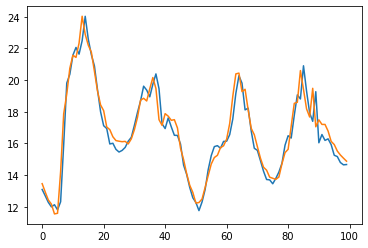

In [33]:
plot_predictions1(model2, X2_test, y2_test)

## Multivariate Forecasting

In [34]:
# contatenate temperature and pressure
p_temp_df = pd.concat([df['p (mbar)'], temp_df], axis=1)
p_temp_df.head()

,p (mbar),Temperature,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,
2009-01-01 01:00:00,996.50,-8.05,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,996.62,-8.88,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,996.84,-8.81,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,996.99,-9.05,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,997.46,-9.63,0.965926,0.258819,0.012916,0.999917


In [35]:
# window making function
def df_to_X_y3(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = [df_as_np[i+window_size][0], df_as_np[i+window_size][1]]
    y.append(label)
  return np.array(X), np.array(y)

In [36]:
X3, y3 = df_to_X_y3(p_temp_df)
X3.shape, y3.shape   

((70084, 7, 6), (70084, 2))

7 is the no of hrs( window length), 6 is the training variables, 2 is temp and pressure|

In [37]:
# Split the model
X3_train, y3_train = X3[:60000], y3[:60000]
X3_val, y3_val = X3[60000:65000], y3[60000:65000]
X3_test, y3_test = X3[65000:], y3[65000:]
X3_train.shape, y3_train.shape, X3_val.shape, y3_val.shape, X3_test.shape, y3_test.shape

((60000, 7, 6), (60000, 2), (5000, 7, 6), (5000, 2), (5084, 7, 6), (5084, 2))

#### Standardizing

In [38]:
# Calculate the mean and standard deviation for pressure (column 0) and temperature (column 1) separately in the training data
p_training_mean3 = np.mean(X3_train[:, :, 0])
p_training_std3 = np.std(X3_train[:, :, 0])

temp_training_mean3 = np.mean(X3_train[:, :, 1])
temp_training_std3 = np.std(X3_train[:, :, 1])

def preprocess3(X):
  # Standardize the pressure and temperature values in the input data using the calculated mean and standard deviation
  X[:, :, 0] = (X[:, :, 0] - p_training_mean3) / p_training_std3
  X[:, :, 1] = (X[:, :, 1] - temp_training_mean3) / temp_training_std3

def preprocess_output3(y):
  # Standardize the output labels (pressure and temperature) using the same mean and standard deviation values
  y[:, 0] = (y[:, 0] - p_training_mean3) / p_training_std3
  y[:, 1] = (y[:, 1] - temp_training_mean3) / temp_training_std3
  return y

#### Preprocess functions
Results of the standardized input features for each dataset.

In [39]:
preprocess3(X3_train)
preprocess3(X3_val)
preprocess3(X3_test)

In [40]:
preprocess_output3(y3_train)
preprocess_output3(y3_val)
preprocess_output3(y3_test)

array([[-0.7934386 ,  0.41245076],
       [-0.76312281,  0.35368268],
       [-0.72189335,  0.32312327],
       ...,
       [ 1.48145784, -1.43051636],
       [ 1.41597574, -1.44697142],
       [ 1.35049365, -1.56920903]])

#### Making a new model

In [41]:
# Making a new model using Sequential API
model3 = Sequential()

# Adding an input layer with shape (7, 6)
model3.add(InputLayer((7, 6)))

# Adding an LSTM layer with 64 units
model3.add(LSTM(64))

# Adding a Dense layer with 8 units and ReLU activation function
model3.add(Dense(8, activation='relu'))

# Adding a Dense layer with 2 units and linear activation function
model3.add(Dense(2, activation='linear'))

# Displaying the summary of the model
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                18176     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 2)                 18        
                                                                 
Total params: 18714 (73.10 KB)
Trainable params: 18714 (73.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
# Create a ModelCheckpoint to save the best model during training
cp3 = ModelCheckpoint('model3/', save_best_only=True)

# Compile the model using Mean Squared Error as the loss function, Adam optimizer with a learning rate of 0.0001,
# and Root Mean Squared Error as the evaluation metric
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [43]:
# Fitting the model to the training data for 10 epochs, validating on the validation data, and using ModelCheckpoint callback
model3.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=10, callbacks=[cp3])

Epoch 1/10
1875/1875 [==============================] - ETA: 0s - loss: 0.1558 - root_mean_squared_error: 0.3948INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


1875/1875 [==============================] - 33s 16ms/step - loss: 0.1558 - root_mean_squared_error: 0.3948 - val_loss: 0.0310 - val_root_mean_squared_error: 0.1760
Epoch 2/10
1873/1875 [============================>.] - ETA: 0s - loss: 0.0234 - root_mean_squared_error: 0.1529INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


1875/1875 [==============================] - 22s 12ms/step - loss: 0.0234 - root_mean_squared_error: 0.1528 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1242
Epoch 3/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.0122 - root_mean_squared_error: 0.1105INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


1875/1875 [==============================] - 18s 10ms/step - loss: 0.0122 - root_mean_squared_error: 0.1105 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0910
Epoch 4/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0081 - root_mean_squared_error: 0.0898INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


1875/1875 [==============================] - 20s 11ms/step - loss: 0.0081 - root_mean_squared_error: 0.0898 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0761
Epoch 5/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0065 - root_mean_squared_error: 0.0808INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


1875/1875 [==============================] - 18s 10ms/step - loss: 0.0065 - root_mean_squared_error: 0.0808 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0704
Epoch 6/10
1865/1875 [============================>.] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0761INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


1875/1875 [==============================] - 16s 8ms/step - loss: 0.0058 - root_mean_squared_error: 0.0761 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0670
Epoch 7/10
1861/1875 [============================>.] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0734INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


1875/1875 [==============================] - 13s 7ms/step - loss: 0.0054 - root_mean_squared_error: 0.0734 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0645
Epoch 8/10
1865/1875 [============================>.] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0719INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


1875/1875 [==============================] - 12s 6ms/step - loss: 0.0052 - root_mean_squared_error: 0.0719 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0619
Epoch 9/10
1868/1875 [============================>.] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0710INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


1875/1875 [==============================] - 14s 7ms/step - loss: 0.0050 - root_mean_squared_error: 0.0710 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0615
Epoch 10/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0050 - root_mean_squared_error: 0.0705 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0620


#### Predictions(pressure and temp) and plotting

In [44]:
def plot_predictions2(model, X, y, start=0, end=100):
  # Making predictions using the input data
  predictions = model.predict(X)
  
  # Extracting predicted and actual values for temperature and pressure
  p_preds, temp_preds = predictions[:, 0], predictions[:, 1]
  p_actuals, temp_actuals = y[:, 0], y[:, 1]
  
  # Creating a DataFrame to store and display the predictions and actual values
  df = pd.DataFrame(data={'Temperature Predictions': temp_preds,
                          'Temperature Actuals':temp_actuals,
                          'Pressure Predictions': p_preds,
                          'Pressure Actuals': p_actuals
                          })
  
  # Plotting the temperature and pressure predictions and actual values within the specified range
  plt.plot(df['Temperature Predictions'][start:end], label='Temperature Predictions')
  plt.plot(df['Temperature Actuals'][start:end], label='Temperature Actuals')
  plt.plot(df['Pressure Predictions'][start:end], label='Pressure Predictions')
  plt.plot(df['Pressure Actuals'][start:end], label='Pressure Actuals')
  
  # Returning the DataFrame for further analysis if needed
  return df[start:end]

159/159 [==============================] - 1s 3ms/step


,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,0.394915,0.412451,-0.770675,-0.793439
1,0.351745,0.353683,-0.761016,-0.763123
2,0.315301,0.323123,-0.727488,-0.721893
3,0.319730,0.250251,-0.675293,-0.652773
4,0.278681,0.254952,-0.587432,-0.652773
...,...,...,...,...
95,0.685219,0.716869,-0.397875,-0.416310
96,0.648846,0.687485,-0.402577,-0.399333
97,0.636048,0.663978,-0.388477,-0.399333
98,0.638984,0.641646,-0.380351,-0.400546


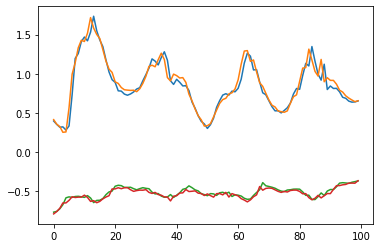

In [45]:
# Calling the plot_predictions2 function with the trained model and test data
plot_predictions2(model3, X3_test, y3_test)

#### Post proccessing

In [46]:
# Function to post-process temperature predictions
def postprocess_temp(arr):
    # Rescaling the temperature predictions using training mean and standard deviation
    arr = (arr * temp_training_std3) + temp_training_mean3
    return arr

# Function to post-process pressure predictions
def postprocess_p(arr):
    # Rescaling the pressure predictions using training mean and standard deviation
    arr = (arr * p_training_std3) + p_training_mean3
    return arr

In [47]:
# Defining a function to plot predictions with post-processing
def plot_predictions2(model, X, y, start=0, end=100):
    # Making predictions using the input data
    predictions = model.predict(X)
    
    # Post-processing temperature and pressure predictions and actual values
    p_preds, temp_preds = postprocess_p(predictions[:, 0]), postprocess_temp(predictions[:, 1])
    p_actuals, temp_actuals = postprocess_p(y[:, 0]), postprocess_temp(y[:, 1])
    
    # Creating a DataFrame to store and display the post-processed predictions and actual values
    df = pd.DataFrame(data={'Temperature Predictions': temp_preds,
                            'Temperature Actuals': temp_actuals,
                            'Pressure Predictions': p_preds,
                            'Pressure Actuals': p_actuals
                            })
    
    # Plotting the post-processed temperature and pressure predictions and actual values within the specified range
    plt.plot(df['Temperature Predictions'][start:end], label='Temperature Predictions')
    plt.plot(df['Temperature Actuals'][start:end], label='Temperature Actuals')
    plt.plot(df['Pressure Predictions'][start:end], label='Pressure Predictions')
    plt.plot(df['Pressure Actuals'][start:end], label='Pressure Actuals')
    
    # Returning the DataFrame for further analysis if needed
    return df[start:end]

159/159 [==============================] - 1s 3ms/step


,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,12.780807,12.93,982.617737,982.43
1,12.413517,12.43,982.697388,982.68
2,12.103453,12.17,982.973877,983.02
3,12.141128,11.55,983.404297,983.59
4,11.791883,11.59,984.128845,983.59
...,...,...,...,...
95,15.250717,15.52,985.692078,985.54
96,14.941254,15.27,985.653259,985.68
97,14.832370,15.07,985.769531,985.68
98,14.857349,14.88,985.836548,985.67


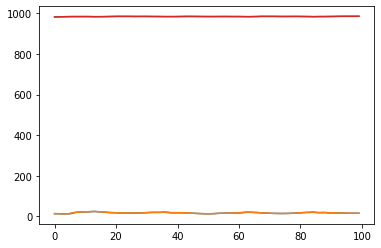

In [48]:
# Running the plot_predictions2 function with model3, X3_test, and y3_test
post_processed_df = plot_predictions2(model3, X3_test, y3_test)

# Displaying the resulting DataFrame showing post-processed temperature and pressure predictions along with actual values
post_processed_df

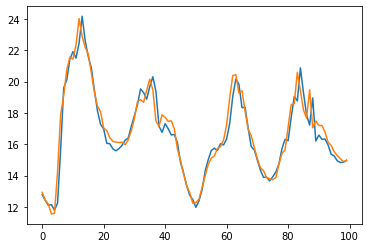

In [49]:
# Setting the start and end indices for the subset of data to be visualized
start, end = 0, 100

# Plotting the subset of Temperature Predictions and Actuals from the post_processed_df DataFrame
plt.plot(post_processed_df['Temperature Predictions'][start:end], label='Temperature Predictions')
plt.plot(post_processed_df['Temperature Actuals'][start:end], label='Temperature Actuals')

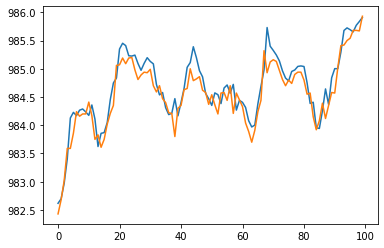

In [50]:
# Plotting the subset of Pressure Predictions and Actuals from the post_processed_df DataFrame
plt.plot(post_processed_df['Pressure Predictions'][start:end])
plt.plot(post_processed_df['Pressure Actuals'][start:end])